In [1]:
import os
import sys

import numpy as np
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import copy
from PIL import Image
from torch.utils.data import Dataset
from torchvision.datasets import ImageFolder
from torchvision.datasets.folder import IMG_EXTENSIONS
from torch.utils.data.sampler import WeightedRandomSampler, RandomSampler, BatchSampler
from torch.utils.data import DataLoader
from torchvision import transforms
import tensorflow as tf 
import random
from math import floor
import itertools
from torch._utils import _accumulate
from torch import randperm
plt.ion()


In [2]:
class Subset(ImageFolder):
    def __init__(self, dataset, indices):
        self.dataset = dataset
        print(indices.numpy().shape)
        self.indices = indices.numpy()
        self.classes = dataset.classes
        self.class_to_idx = dataset.class_to_idx
        self.imgs = np.array(dataset.imgs)[self.indices]

    def __getitem__(self, idx):
        return self.dataset[self.indices[idx]]

    def __len__(self):
        return len(self.indices)


def create_lengths(dataset,train,val,test):
    assert train+test+val >= 0.9999
    assert train+test+val <= 1.0001
    length = len(dataset)
    trn = floor(train*length)
    val = floor(val *length)
    test = length -trn - val
    assert length == trn+val+test
    return [trn,val,test]

def stratefied_train_valid_split(dataset, test_size=0.20, shuffle=False, random_seed=0):
    """ Return a list of splitted indices from a DataSet in a stratefied fashion.
    Indices can be used with DataLoader to build a train and validation set.

    Arguments:
        A Dataset
        A test_size, as a float between 0 and 1 (percentage split) or as an int (fixed number split)
        Shuffling True or False
        Random seed
    """
    # get the length of the dataset and the number of classes
    length = dataset.__len__()
    n_classes = len(dataset.classes)
    indices = list(0, length-1)
    train_indices=[]
    test_indices=[]

    # run through the number of classes and look at the class label which is the second element in the tuple
    # get the length of this and then add it to the length class. Then update the start indicies by looking at the
    # previous start indicies and the length of the previous class.
    for i in range(n_classes):
        selector = [x for x in dataset if x[1]==i]
        class_indices = list(itertools.compress(indices, selectors=selector))
        length_class = len(class_indicies)

        if shuffle == True:
            random.seed(random_seed)
            random.shuffle(class_indices)

        if type(test_size) is float:
            split = floor(test_size * length_class)
        elif type(test_size) is int:
            split = test_size
        else:
            raise ValueError('%s should be an int or a float' % str)
        train_indices += class_indices[split:]
        test_indices += class_indices[:split]
    return train_indices, test_indices


def get_weights(dataset):
    """
    We get the weights as the inverse of the amount of times that they appear in the the dataset
    This helps us to upsample the more sparse classes so they occur more often. It will come out so
    that they are sampled on average a uniform distribution for each class.
    :param dataset:
    :return: weights
    """
    print('getting weights')
    length=len(dataset)
    n_classes = len(dataset.classes)
    count=[0]*n_classes
    weights = []
    print('length of dataset is {}'.format(length))
    for i in range(length):
        count[int(dataset.imgs[i,1])] +=1
    print('done counting')
    N = sum(count)
    print(count)
    print(N)
    for i in range(n_classes):
        weights.append(N/count[i])
    return weights

def make_weights_for_balanced_classes(images, nclasses):                        
    count = [0] * nclasses                                                      
    for item in images:
        count[int(item[1])] += 1                                                     
    weight_per_class = [0.] * nclasses                                      
    N = float(sum(count))                                                   
    for i in range(nclasses):                                                   
        weight_per_class[i] = N/float(count[i])                                 
    weight = [0] * len(images)                                              
    for idx, val in enumerate(images):                                          
        weight[idx] = weight_per_class[int(val[1])]                                  
    return weight

def random_split(dataset, lengths):
    """
    Randomly split a dataset into non-overlapping new datasets of given lengths
    ds

    Arguments:
        dataset (Dataset): Dataset to be split
        lengths (iterable): lengths of splits to be produced
    """
    if sum(lengths) != len(dataset):
        raise ValueError("Sum of input lengths does not equal the length of the input dataset!")

    indices = randperm(sum(lengths))
    return [Subset(dataset, indices[offset - length:offset]) for offset, length in zip(_accumulate(lengths), lengths)]

In [3]:
#TODO: Turn this into a function and add arguments for data augementation.
#def get_dataloaders(datadir,train_split,val_split, test_split, batch_size,)
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomSizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Scale(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


## This is because torch vision does not support tif files
IMG_EXTENSIONS.append('tif')
BATCH_SIZE = 128


#SPLITS for train test validation
train_size=0.8
val_size= 0.1
test_size=0.1

#get the main folder for our classification problem to feed from
datadir = os.path.join(os.getcwd(),'classification')
data = ImageFolder(datadir, transform=data_transforms['val'])

#lengths to divide up the data into
lengths = create_lengths(data,train_size,val_size,test_size)

# split the data into train, test, val
train_data, val_data, test_data = random_split(data, lengths=lengths)


# because we are splitting on the fly we need to calculate the weights in the training set to upsample by
weights = make_weights_for_balanced_classes(train_data.imgs, len(data.classes))                                                                
weights = torch.DoubleTensor(weights)
print("the train weights are {}".format(weights))
print(len(weights))

# create Samplers. For training we want to use weighted random samplers at test time we will use unweighted
train_sampler = WeightedRandomSampler(weights=weights, num_samples=len(weights))
val_sampler = RandomSampler(val_data)


# Create dataloaders
train_loader = DataLoader(dataset=train_data,
                          batch_size=BATCH_SIZE,
                          shuffle=False,
                          pin_memory=True,
                          sampler=train_sampler,
                          drop_last=True)

val_loader = DataLoader(dataset=val_data,
                        batch_size=BATCH_SIZE,
                        shuffle=False,
                        pin_memory=True,
                        sampler=val_sampler,
                        drop_last=True)
dataset_sizes={'train':len(train_data),'val':len(val_data)}
dataloaders={'train':train_loader, 'val':val_loader}

class_names = data.classes
use_gpu = torch.cuda.is_available()

(17600,)
(2200,)
(2200,)
the train weights are 
  1.0951
  1.0951
  1.0951
   ⋮    
  1.0951
  1.0951
  1.0951
[torch.DoubleTensor of size 17600]

17600


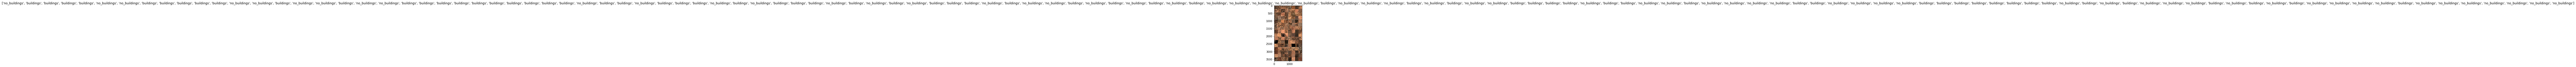

In [4]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [5]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        count=1
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for data in dataloaders[phase]:
                # get the inputs
                inputs, labels = data

                # wrap them in Variable
                if use_gpu:
                    inputs = Variable(inputs.cuda())
                    labels = Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.data[0] * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                print(running_corrects/(count*BATCH_SIZE))
                """
                if count % 100:
                    cur_loss = running_loss / (count*BATCH_SIZE)
                    cur_acc = running_corrects / (count*BATCH_SIZE)
                    print('{} Loss: {:.4f} Acc: {:.4}'.format(phase, cur_loss, cur_acc))
                count+=1
                """
                count+=1
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [6]:
def visualize_model(model, num_images=6):
    images_so_far = 0
    fig = plt.figure()

    for i, data in enumerate(dataloaders['val']):
        inputs, labels = data
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)

        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)

        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(num_images//2, 2, images_so_far)
            ax.axis('off')
            ax.set_title('predicted: {}'.format(class_names[preds[j]]))
            imshow(inputs.cpu().data[j])

            if images_so_far == num_images:
                return

In [7]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

if use_gpu:
    model_ft = model_ft.cuda()

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [22]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=12)

Epoch 0/11
----------
0.5078125
0.55859375
0.5729166666666666
0.611328125
0.625
0.6380208333333334
0.6484375
0.6689453125
0.6918402777777778
0.7078125
0.7223011363636364
0.734375
0.7481971153846154
0.7594866071428571
0.7697916666666667
0.77734375
0.78125
0.7868923611111112
0.7911184210526315
0.796484375
0.8035714285714286
0.8082386363636364
0.8108016304347826
0.8154296875
0.82
0.8236177884615384
0.8292824074074074
0.83203125
0.8351293103448276
0.8375
0.8394657258064516
0.8427734375
0.8463541666666666
0.8499540441176471
0.8522321428571429
0.8552517361111112
0.8574746621621622
0.8589638157894737
0.8607772435897436
0.8626953125
0.8650914634146342
0.8668154761904762
0.8693677325581395
0.8709161931818182
0.8732638888888888
0.8755095108695652
0.8771609042553191
0.87841796875
0.8797831632653061
0.87984375
0.8811274509803921
0.8822115384615384
0.8832547169811321
0.8842592592592593
0.8853693181818182
0.8864397321428571
0.8869243421052632
0.8877963362068966
0.8886387711864406
0.8889322916666667


KeyboardInterrupt: 